# Rank-Biased Overlap Testing

Rank-biased overlap (rbo) is an evaluation method to compare query results of seach engines. It takes the first k results and compares them over multiple lists. With p one can weight how much a higher ranking, that is not in both lists should impact the score. If p is 1, then the order does not matter. Usually a p of 0.9>p>0.98 is usefull...


In [1]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

import save_load_models as save_load

/home/abecker/.conda/envs/BachelorEnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

In [2]:
reload(save_load)

multiMini = './Models/multilingual-MiniLM'
msMarcoMini = './Models/msmarco-MiniLM'
wikimedicalBioBert = './Models/wikimedical-BioBERT'
sPubMedBert = './Models/SPubMedBERT'

sPubMedBertFinetunedv1 = './Models/Finetunedv1/SPubMedBERT/end_model'
sPubMedBertFinetunedv2 = './Models/Finetunedv2/SPubMedBERT/end_model'
sPubMedBertFinetunedNfcorpus = './Models/Finetuned/SPubMedBERT-v1-nfcorpus'

model = save_load.load_model_sentencetransformer(sPubMedBertFinetunedNfcorpus)

In [3]:
'''
MultiMini
MsMarcoMini
WikiMedicalBERT
SPubMedBERT

SPubMedBERTFinetunedv1
SPubMedBERTFinetunedv2
SPubMedBERTFinetunedNfcorpus
'''
model_name = "SPubMedBERTFinetunedNfcorpus"

### Load Embeddings

In [4]:
multiMiniDir = './Embeddings/multilingual-MiniLM/'
msMarcoMiniDir = './Embeddings/msmarco-MiniLM/'
wikimedicalBioBertDir = './Embeddings/wikimedical-BioBERT/'
sPubMedBertDir = './Embeddings/SPubMedBERT/'

sPubMedBertFinetunedv1Dir = './Embeddings/Finetunedv1/SPubMedBERT/'
sPubMedBertFinetunedv2Dir = './Embeddings/Finetunedv2/SPubMedBERT/'
sPubMedBertFinetunedNfcorpusDir = './Embeddings/FinetunedNfCorpus/SPubMedBERT/'

In [5]:
import vector_search as vs
reload(vs)
# RBO_Test_Data_Subset ~50k

embedding_dir = sPubMedBertFinetunedNfcorpusDir + 'RBO_Test_Data_Subset'
embeddings, ref_list = vs.add_embeddings_to_nparray_from_dir(embedding_dir) 

### Load Queries

Load Query pairs from json file.

In [6]:
import json
query_list = []
with open('./Data/synonym_sentence_pairs.json', 'r') as file:
    query_list = json.load(file)
print("Example queries:")
print(*query_list[5:15], sep='\n')

Example queries:
['Genetic predisposition to Parkinson’s disease.', 'Genetic predisposition to Parkinsonism.']
['Current advancements in immunotherapy for melanoma.', 'Current advancements in immunotherapy for skin cancer.']
['Role of antibiotics in the treatment of bacterial meningitis.', 'Role of antibiotics in the treatment of bacterial brain inflammation.']
['Pathophysiology of hypertrophic cardiomyopathy.', 'Pathophysiology of thickened heart muscle disease.']
['Impacts of gestational diabetes on neonatal outcomes.', 'Impacts of pregnancy-related diabetes on neonatal outcomes.']
['Pharmacological interventions for neuropathic pain.', 'Pharmacological interventions for nerve pain.']
['Stem cell therapy applications in spinal cord injuries.', 'Stem cell therapy applications in spinal injuries.']
['Prevention strategies for deep vein thrombosis in ICU patients.', 'Prevention strategies for DVT in ICU patients.']
['Clinical guidelines for diagnosing irritable bowel syndrome.', 'Clinic

### Calculate Query Results

Calculate Query resuts for each of the triplets. Save the resulting similarity rankings and article Ids in a List for later use.

In [7]:
import vector_search as vs
reload(vs)

n = 100

query_refs = []
query_sims = []
query_embeds = []
query_types = {'Title':0,'Abstract':0}

for queries in query_list:
    query_ref, query_similarity, query_embeddings = vs.query_articles(queries, embeddings, np.reshape(ref_list, (-1, 1)), model, print_results=False, n=n)
    query_refs.append([[elem.split('-')[1] for elem in row] for row in np.squeeze(query_ref).tolist()])
    #query_refs.append(query_ref)
    query_sims.append(query_sims)
    query_embeds.append(query_embeddings)
    for ref in np.array(query_ref).flatten():
        query_types[ref.split('-')[0]] +=1
#query_refs has shape (x,y,n), when using m queries with each n versions

In [8]:
def remove_duplicates(lst):
    seen = set()
    return [x for x in lst if not (x in seen or seen.add(x))]
    
query_refs_no_duplicates = np.empty_like(query_refs).tolist()

for idx, query_res in enumerate(query_refs):
    for jdx, pair_res in enumerate(query_res):
        unique_res = remove_duplicates(pair_res)
        query_refs_no_duplicates[idx][jdx] = unique_res

### RBO - pairs
Calulate the RBO-score for pairs of equivalent sentences.

In [9]:
embeddings_count = sum(query_types.values())

percentages = {k: (v / embeddings_count) * 100 for k, v in query_types.items()}

for key, value in percentages.items():
    print(f"{key}: {value:.2f}%")

print(query_types)
#print(np.array(query_refs).shape)

Title: 63.41%
Abstract: 36.59%
{'Title': 25364, 'Abstract': 14636}


In [10]:
import rbo_copy as rbo_c
import statistics
reload(rbo_c)
#from rbo_copy import rbo
# Can't reload if import like that
scores = []

k = 50
p = 0.95

q_result_count = len(set(np.array(query_refs).flatten()))

for idx, sim_ranking in enumerate(query_refs_no_duplicates):
    rbo_score = rbo_c.rbo(sim_ranking[0], sim_ranking[1], k=k, p=p, ext=True)
    scores.append(rbo_score)
    print(f"For Query {idx+1} with pair:\n{query_list[idx]}")
    print("Query 1 - Query 2: ", rbo_score)
    print(u'\u2500' * 50)

print(u'\u2500' * 50)
print(f"Overall Median of RBO-Scores: {statistics.median(scores):.3f}")
print(f"Overall Mean of RBO-Scores: {statistics.mean(scores):.3f}")
print("Queried documents count: ", q_result_count)
print("Queried documents average: ", q_result_count/len(query_list))

For Query 1 with pair:
['Emergency treatment of sepsis.', 'Emergency treatment of septicemia.']
Query 1 - Query 2:  0.5943351238236096
──────────────────────────────────────────────────
For Query 2 with pair:
['Choosing the point of care for acute health problems.', 'Choosing the point of care for acute medical conditions.']
Query 1 - Query 2:  0.823956250920655
──────────────────────────────────────────────────
For Query 3 with pair:
['COVID and kidney disease.', 'COVID and renal disease.']
Query 1 - Query 2:  0.8200128523445605
──────────────────────────────────────────────────
For Query 4 with pair:
['How does delirium impact the onset of dementia?', 'How does confusion impact the onset of dementia?']
Query 1 - Query 2:  0.12890956418989008
──────────────────────────────────────────────────
For Query 5 with pair:
['Chronic kidney disease management in elderly patients.', 'Chronic renal disease management in elderly patients.']
Query 1 - Query 2:  0.8824574571536186
─────────────────

[]

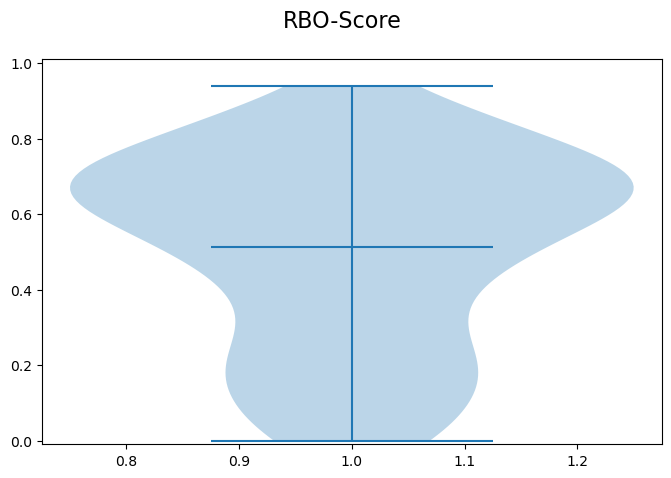

In [11]:
fig = plt.figure(figsize=(8, 5))
fig.suptitle('RBO-Score', fontsize=16)

plt.violinplot(scores, showmeans=True, showextrema= True)
plt.ylim(ymin=-0.01, ymax=1.01)

plt.savefig(f'Plots/RBOScore/{model_name}.png')
plt.plot()

### Print results for queries


In [12]:
reload(vs)
query_idx = 22
print("Show Articles for Query: ", query_list[query_idx][0])
print(query_refs[query_idx][0][:10])
articles = vs.get_articles(query_refs[query_idx][0][:10], dir_path=embedding_dir)

Show Articles for Query:  Use of wearable biosensors for cardiac arrhythmias.
['PMC5674214', 'PMC5676989', 'PMC7284328', 'PMC8839669', 'PMC8836661', 'PMC8838158', 'PMC7284328', 'PMC8839540', 'PMC8838158', 'PMC8840211']

 Filename:  PMC005xxxxxx/PMC5674214.xml

Title:
 A review on ZnO-based electrical biosensors for cardiac biomarker detection

Abstract:
 Over the past few decades zinc oxide (ZnO)-based thin films and nanostructures have shown unprecedented performance in a wide range of applications. In particular, owing to high isoelectric point, biocompatibility and other multifunctional characteristics, ZnO has extensively been studied as a transduction material for biosensor development. The fascinating properties of ZnO help retain biological activity of the immobilized biomolecule and help in achieving enhanced sensing performance. As a consequence of recent advancements in this multidisciplinary field, diagnostic biosensors are expanding beyond traditional clinical labs to point